Loading the best trained model...
✅ Model loaded successfully.
Found 840 images belonging to 2 classes.
Classes: {0: 'Normal', 1: 'Tuberculosis'}

Generating Grad-CAM visualizations for 6 random examples...


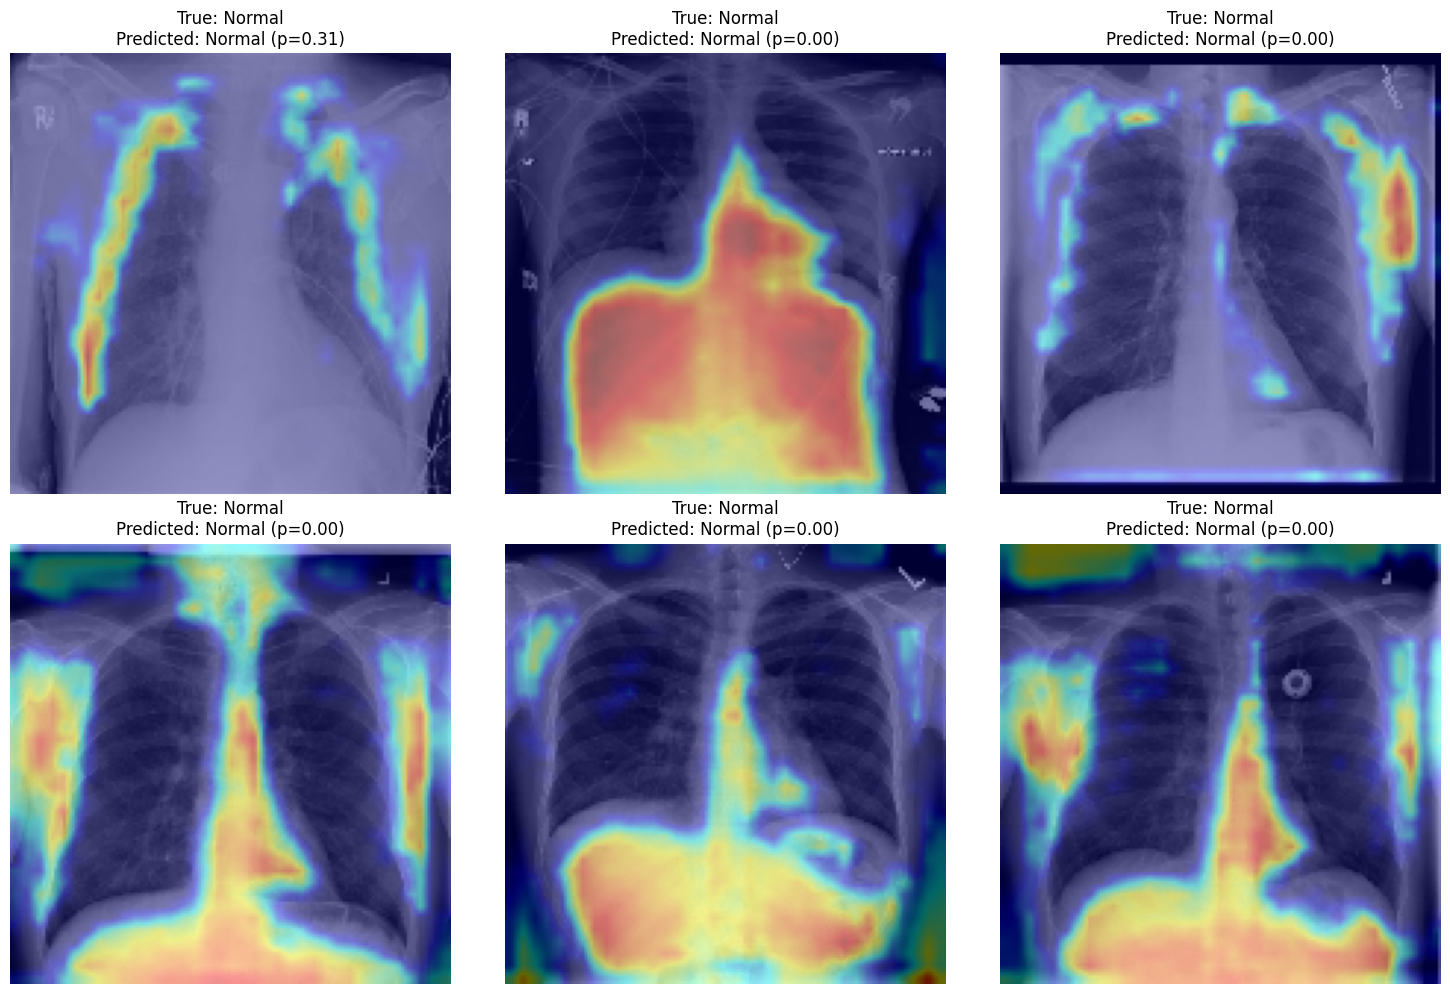

In [ ]:
# ==============================================================================
#              MODEL EXPLAINABILITY WITH GRAD-CAM VISUALIZATIONS
# ==============================================================================

# --- 1. Library Imports and Configuration ---
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# --- 2. Load Best Model and Validation Data ---
print("Loading the best trained model...")
model = load_model('../model/tb_cnn_model_best.keras')
print("✅ Model loaded successfully.")

# Prepare a data generator to fetch validation images for visualization
DATA_DIR = os.path.join('..', 'data', 'TB_Chest_Radiography_Database')
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    subset='validation',
    target_size=(150, 150),
    batch_size=1, # Process one image at a time
    class_mode='binary',
    shuffle=True # Shuffle to get random examples each time
)
# Create a mapping from class index to class name
idx_to_class = {v: k for k, v in validation_generator.class_indices.items()}
print(f"Classes: {idx_to_class}")

# --- 3. Grad-CAM Helper Functions ---
def find_last_conv_layer(model):
    """Finds the name of the last convolutional layer in the model."""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Generates a Grad-CAM heatmap. This robust method manually reconstructs
    the model graph, which works reliably with loaded Sequential models.
    """
    # 1. Create a new model input
    inputs = tf.keras.Input(shape=img_array.shape[1:])
    
    # 2. Manually reconstruct the graph by iterating through layers
    x = inputs
    conv_output = None
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            conv_output = x # Capture the output of the target conv layer
            
    # 3. Create the Grad-CAM model with the reconstructed graph
    grad_model = tf.keras.Model(inputs, [conv_output, x])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, 0]

    # Calculate gradients and the heatmap
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8) # Normalize
    return heatmap

def overlay_heatmap(heatmap, img_bgr, alpha=0.4):
    """Superimposes the heatmap on the original image."""
    heatmap = cv2.resize(heatmap, (img_bgr.shape[1], img_bgr.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) 
    return cv2.addWeighted(heatmap_color, alpha, img_bgr, 1 - alpha, 0)

# --- 4. Generate and Display Visualizations ---
print("\nGenerating Grad-CAM visualizations for 6 random examples...")
last_conv_layer_name = find_last_conv_layer(model)
plt.figure(figsize=(15, 10))

for i in range(6):
    # Fetch a random image and its true label
    img_tensor, y_true_label = next(validation_generator)
    
    # Make a prediction
    pred_score = model.predict(img_tensor, verbose=0)[0][0]
    y_pred_label = 1 if pred_score >= 0.5 else 0

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
    
    # Overlay heatmap on the original image
    img_bgr = cv2.cvtColor((img_tensor[0] * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    overlaid_img = overlay_heatmap(heatmap, img_bgr)
    
    # Convert back to RGB for displaying with matplotlib
    img_to_show = cv2.cvtColor(overlaid_img, cv2.COLOR_BGR2RGB)
    
    # Plot the result
    ax = plt.subplot(2, 3, i + 1)
    true_class = idx_to_class[int(y_true_label[0])]
    pred_class = idx_to_class[y_pred_label]
    plt.title(f"True: {true_class}\nPredicted: {pred_class} (p={pred_score:.2f})")
    plt.imshow(img_to_show)
    plt.axis('off')

plt.tight_layout()
plt.show()